In [287]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from itertools import product
import shapely
import networkx as nx
import seaborn as sns

%matplotlib inline

In [2]:
def find_recursive_csv_files(location='.'):
    foo = []
    for root, subdirs, files in os.walk(location):
        foo.extend([(root + '/' + x) for x in files if x[-4:] == '.csv'])
    return foo

## Loading LSOA geoshape data

In [3]:
data = gpd.read_file(
    './data/Lower_Layer_Super_Output_Areas_December_2011_Full_Extent__Boundaries_in_England_and_Wales.shp')

data.set_index('objectid')
data['place_name'] = data['lsoa11nm'].apply(lambda x: x[:-4].rstrip())

print(data.info())

data.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 8 columns):
objectid      34753 non-null int64
lsoa11cd      34753 non-null object
lsoa11nm      34753 non-null object
lsoa11nmw     34753 non-null object
st_areasha    34753 non-null float64
st_lengths    34753 non-null float64
geometry      34753 non-null object
place_name    34753 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 2.1+ MB
None


,objectid,lsoa11cd,lsoa11nm,lsoa11nmw,st_areasha,st_lengths,geometry,place_name
0,1,E01000001,City of London 001A,City of London 001A,129865.337597,2635.781429,"POLYGON ((532153.3511221728 181867.6373986569,...",City of London
1,2,E01000002,City of London 001B,City of London 001B,228419.333117,2708.052040,"POLYGON ((532636.3044484088 181926.2382983296,...",City of London
2,3,E01000003,City of London 001C,City of London 001C,59054.013119,1224.770897,"POLYGON ((532155.5076535332 182165.4032334399,...",City of London
3,4,E01000005,City of London 001E,City of London 001E,189577.165141,2275.832056,"POLYGON ((533620.8853745657 181402.5745685115,...",City of London
4,5,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,146536.520438,1966.162225,"POLYGON ((545128.7281072272 184311.0094698063,...",Barking and Dagenham


## Load LSOA Local Authority Info

In [4]:
lsoa_la_df = pd.read_csv('./data/lsoa_boundaries.csv')

print(lsoa_la_df.info())

lsoa_la_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171372 entries, 0 to 171371
Data columns (total 12 columns):
OA11CD      171372 non-null object
LAD16CD     171372 non-null object
LAD16NM     171372 non-null object
LSOA11CD    171372 non-null object
LSOA11NM    171372 non-null object
MSOA11CD    171372 non-null object
MSOA11NM    171372 non-null object
LEP17CD1    171372 non-null object
LEP17NM1    171372 non-null object
LEP17CD2    13182 non-null object
LEP17NM2    13182 non-null object
FID         171372 non-null int64
dtypes: int64(1), object(11)
memory usage: 15.7+ MB
None


,OA11CD,LAD16CD,LAD16NM,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LEP17CD1,LEP17NM1,LEP17CD2,LEP17NM2,FID
0,E00052830,E08000031,Wolverhampton,E01010462,Wolverhampton 004C,E02002152,Wolverhampton 004,E37000001,Black Country,NaN,NaN,3001
1,E00052777,E08000031,Wolverhampton,E01010449,Wolverhampton 029A,E02002177,Wolverhampton 029,E37000001,Black Country,NaN,NaN,3002
2,E00052627,E08000031,Wolverhampton,E01010420,Wolverhampton 023C,E02002171,Wolverhampton 023,E37000001,Black Country,NaN,NaN,3003
3,E00052930,E08000031,Wolverhampton,E01010485,Wolverhampton 007D,E02002155,Wolverhampton 007,E37000001,Black Country,NaN,NaN,3004
4,E00052878,E08000031,Wolverhampton,E01010475,Wolverhampton 015D,E02002163,Wolverhampton 015,E37000001,Black Country,NaN,NaN,3005


## Loading Crime Data

In [7]:
df = pd.concat([pd.read_csv(x, index_col='Crime ID', parse_dates=[1]) for x in find_recursive_csv_files()])

print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 7096835 entries, 69419d07ef0810c62964c6ac9af7d7004ba5013df2a0165cb0ecff282fa2009a to 75a364bc060252eb354a9c910f8238061d39f3438a9b7ca1aa89f54b7355287a
Data columns (total 11 columns):
Month                    datetime64[ns]
Reported by              object
Falls within             object
Longitude                float64
Latitude                 float64
Location                 object
LSOA code                object
LSOA name                object
Crime type               object
Last outcome category    object
Context                  float64
dtypes: datetime64[ns](1), float64(3), object(7)
memory usage: 649.7+ MB
None


,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
Crime ID,,,,,,,,,,,
69419d07ef0810c62964c6ac9af7d7004ba5013df2a0165cb0ecff282fa2009a,2017-12-01,West Yorkshire Police,West Yorkshire Police,-1.409547,53.598298,On or near Ash Mount,E01007329,Barnsley 003A,Violence and sexual offences,Under investigation,NaN
0c857058e3567075ea2561d244b08b557c798a4a777e16c3e5691b2b2e5327d3,2017-12-01,West Yorkshire Police,West Yorkshire Police,-1.409547,53.598298,On or near Ash Mount,E01007329,Barnsley 003A,Other crime,Under investigation,NaN
ec0c5d0aa205ee3ff6591df5f3d834eb83da860d3c1ab83c9f1e5e4b5b1576dd,2017-12-01,West Yorkshire Police,West Yorkshire Police,-1.409547,53.598298,On or near Ash Mount,E01007329,Barnsley 003A,Other crime,Under investigation,NaN
NaN,2017-12-01,West Yorkshire Police,West Yorkshire Police,-1.550626,53.597400,On or near Swithen Hill,E01007359,Barnsley 005C,Anti-social behaviour,NaN,NaN
ce4b10db4be860b8d8899c594e8861fa3417c672910fa1b0489d3b8714be45db,2017-12-01,West Yorkshire Police,West Yorkshire Police,-1.863065,53.939035,On or near Low Mill,E01010646,Bradford 001A,Bicycle theft,Investigation complete; no suspect identified,NaN


In [97]:
combined_df = lsoa_la_df.groupby('LSOA11CD').agg('first')[['LAD16NM', 'LEP17NM1']] \
               .reset_index() \
               .rename(columns={'LSOA11CD': 'lsoa11cd'}) \
    .merge(data[['place_name', 'geometry', 'lsoa11cd']], how='left')
    
print(combined_df.info())

combined_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32844 entries, 0 to 32843
Data columns (total 5 columns):
lsoa11cd      32844 non-null object
LAD16NM       32844 non-null object
LEP17NM1      32844 non-null object
place_name    32844 non-null object
geometry      32844 non-null object
dtypes: object(5)
memory usage: 1.5+ MB
None


,lsoa11cd,LAD16NM,LEP17NM1,place_name,geometry
0,E01000001,City of London,London,City of London,"POLYGON ((532153.3511221728 181867.6373986569,..."
1,E01000002,City of London,London,City of London,"POLYGON ((532636.3044484088 181926.2382983296,..."
2,E01000003,City of London,London,City of London,"POLYGON ((532155.5076535332 182165.4032334399,..."
3,E01000005,City of London,London,City of London,"POLYGON ((533620.8853745657 181402.5745685115,..."
4,E01000006,Barking and Dagenham,London,Barking and Dagenham,"POLYGON ((545128.7281072272 184311.0094698063,..."


In [207]:
neighbour_df = pd.DataFrame(
    [(x[1][0], y[1][0], x[1][-1]) for x, y in 
         product(location_df.iterrows(), location_df.iterrows()) 
         if x[1][-1].touches(y[1][-1])], columns=['source', 'target', 'geometry'])

print(neighbour_df.info())

neighbour_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9884 entries, 0 to 9883
Data columns (total 3 columns):
source      9884 non-null object
target      9884 non-null object
geometry    9884 non-null object
dtypes: object(3)
memory usage: 231.7+ KB
None


,source,target,geometry
0,E01004766,E01004767,"POLYGON ((371472.3655950691 411964.8252524126,..."
1,E01004766,E01004768,"POLYGON ((371472.3655950691 411964.8252524126,..."
2,E01004766,E01004772,"POLYGON ((371472.3655950691 411964.8252524126,..."
3,E01004766,E01004773,"POLYGON ((371472.3655950691 411964.8252524126,..."
4,E01004766,E01004774,"POLYGON ((371472.3655950691 411964.8252524126,..."


In [226]:
neighbour_df = pd.DataFrame(
    [(x[1][0], y[1][0], x[1][-1]) for x, y in 
         product(location_df.iloc[0:10].iterrows(), location_df.iloc[0:10].iterrows()) 
         if x[1][-1].touches(y[1][-1])], columns=['source', 'target', 'geometry'])

neighbour_df.head()

,source,target,geometry
0,E01004766,E01004767,"POLYGON ((371472.3655950691 411964.8252524126,..."
1,E01004766,E01004768,"POLYGON ((371472.3655950691 411964.8252524126,..."
2,E01004766,E01004772,"POLYGON ((371472.3655950691 411964.8252524126,..."
3,E01004766,E01004773,"POLYGON ((371472.3655950691 411964.8252524126,..."
4,E01004766,E01004774,"POLYGON ((371472.3655950691 411964.8252524126,..."


In [227]:
location_df = combined_df[(combined_df['LEP17NM1'] == 'Greater Manchester')].copy()

neighbour_df = pd.DataFrame(
    [(x[1][0], y[1][0], x[1][-1]) for x, y in 
         product(location_df.iterrows(), location_df.iterrows()) 
         if x[1][-1].touches(y[1][-1])], columns=['source', 'target', 'geometry']) \
    .rename(columns={'source': 'lsoacd11'}) \
    .merge(df.groupby(['LSOA code', 'Crime type']) \
    .agg('size') \
    .reset_index() \
    .rename(columns={
        'LSOA code': 'lsoacd11',
        'Crime type': 'crime',
        0: 'value'}), on='lsoacd11')
    
print(neighbour_df.info())

neighbour_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116477 entries, 0 to 116476
Data columns (total 5 columns):
lsoacd11    116477 non-null object
target      116477 non-null object
geometry    116477 non-null object
crime       116477 non-null object
value       116477 non-null int64
dtypes: int64(1), object(4)
memory usage: 5.3+ MB
None


,lsoacd11,target,geometry,crime,value
0,E01004766,E01004767,"POLYGON ((371472.3655950691 411964.8252524126,...",Anti-social behaviour,37
1,E01004766,E01004767,"POLYGON ((371472.3655950691 411964.8252524126,...",Bicycle theft,1
2,E01004766,E01004767,"POLYGON ((371472.3655950691 411964.8252524126,...",Burglary,25
3,E01004766,E01004767,"POLYGON ((371472.3655950691 411964.8252524126,...",Criminal damage and arson,35
4,E01004766,E01004767,"POLYGON ((371472.3655950691 411964.8252524126,...",Drugs,4


In [268]:
plotting_df = neighbour_df.groupby(['lsoacd11', 'crime']).first().reset_index()

for name, group in plotting_df.groupby('crime'):
    pass

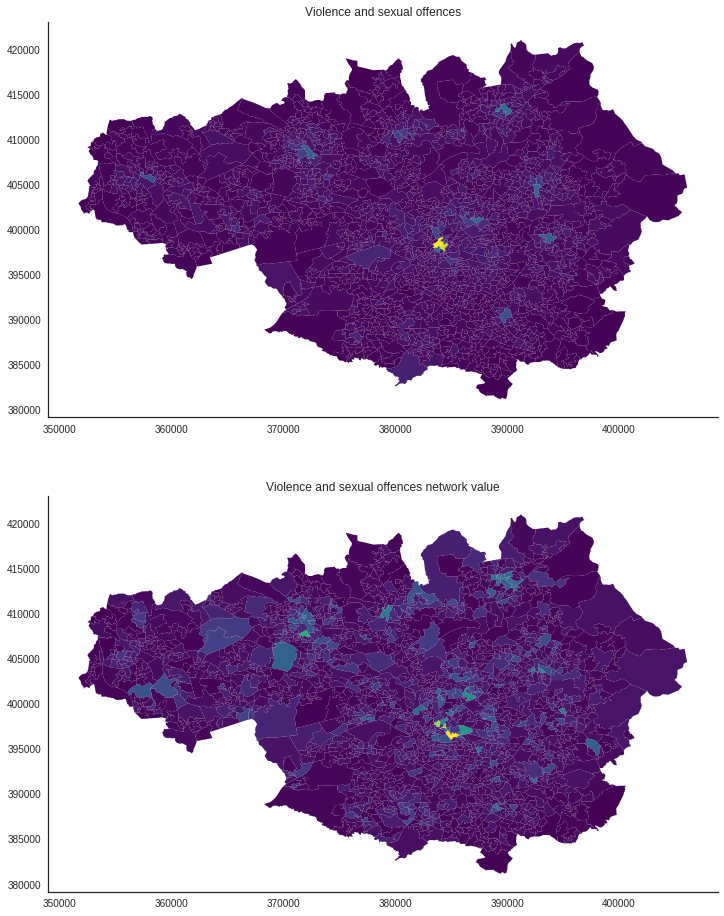

In [301]:

fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(211)

gpd.GeoDataFrame(group).plot('value', cmap='viridis', ax=ax)
ax.set_title(name)


ax = fig.add_subplot(212)

gpd.GeoDataFrame(group).plot('dot_product', cmap='viridis', ax=ax)

ax.set_title('{0} network value'.format(name))

sns.despine(fig=fig)

In [279]:
G = nx.from_pandas_edgelist(group, source='lsoacd11')
group['dot_product'] = nx.adjacency_matrix(G).dot(group['value'])

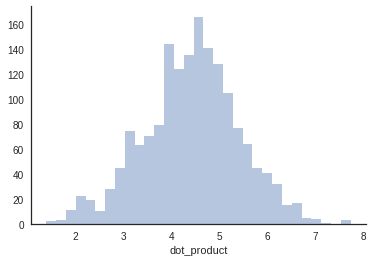

In [305]:
sns.distplot(np.log(group.dot_product), kde=False)
sns.despine()